# Redes Neuronales
## Preparacion de datos para el modelo

In [277]:
import sys
sys.path.append('../')

import Utilidades as ut
import Modelos as md
import numpy as np
import pandas as pd


df_train = pd.read_pickle("../Archivos/Neuronales_entrenamiento.pkl")
df_test = pd.read_pickle("../Archivos/Neuronales_validacion.pkl")

if ('Opportunity_ID' in df_test):
    df_test = df_test.drop(columns=['Opportunity_ID'])

x_train, y_train = ut.split_labels(df_train)
x_test, y_test = ut.split_labels(df_test)

#Convertimos las fechas a numeros (cantidad de dias transcurridos) y luego las normalizamos
x_train, x_test = ut.conversion_fechas(x_train, x_test)
x_train, x_test = ut.codificar_categoricas(x_train, y_train, x_test, modo='catboost')
x_train, x_test = ut.normalizacion_numericas(x_train, x_test, modo='normalizacion')
x_train.shape

/home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(12140, 20)

## Creacion del modelo.

In [271]:
import keras
import tensorflow as tf
from keras import backend
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score, log_loss


x_train_vector = ut.df_a_vector(x_train)
y_train_vector = ut.df_a_vector(y_train)
x_test_vector = ut.df_a_vector(x_test)
y_test_vector = ut.df_a_vector(y_test)

input_dim = x_train.shape[1]
#
alfa = 0.01
#
model = Sequential()
model.add(Dense(96, input_dim=input_dim, kernel_regularizer=l1(alfa), activation='tanh'))
model.add(Dropout(0.39))
model.add(Dense(54, kernel_regularizer=l1(alfa), activation='tanh'))
model.add(Dropout(0.28))
##model.add(Dense(256, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='tanh'))
#model.add(Dropout(0.5))
#model.add(Dense(128, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(64, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='tanh'))
#model.add(Dropout(0.25))
#model.add(Dense(16, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
#model.add(Dense(8, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

def my_loss_fn(y_true, y_pred):
    #squared_difference = tf.square(y_true - y_pred)
    return log_loss(np.array(y_true), np.array(y_pred))




model.compile(loss='binary_crossentropy', optimizer='rmsprop')

backend.set_value(model.optimizer.learning_rate, 0.0016)

best_hparams = ut.hyperparams_from_json('../Archivos/Neuronales')
model = md.get_neural_network_model(best_hparams, x_train.shape[1])

epochs = 250
batch_size = 256


my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Neuronales_Mejor_Modelo.hdf5", 
                                       monitor='val_loss', 
                                       verbose=0,
                                       save_best_only=True, 
                                       mode='min'),
    
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                     min_delta=0.0001,
                                     mode='min',
                                     patience=10),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                      mode='min',
                                      factor=0.5,
                                      min_delta=0.0001,
                                      patience=2,
                                      cooldown=0, 
                                      min_lr=1e-24)
]

#def train(last_best):
#    
#    for a in range(0, 50):
#        model = md.get_neural_network_model(best_hparams, x_train.shape[1])
#        history = model.fit(x_train_vector,
#                            y_train_vector,
#                            validation_data=(x_test_vector, y_test_vector),
#                            **fit_dict)
#        if history.history['val_loss'][-1] < last_best:
#            return
#        
#    
#
#train(0.281)
#Mejor modelo hasta el momento val_loss = 0.311

#Ultimo mejor 0.2809


history = model.fit(x_train_vector,
                    y_train_vector,
                    validation_data=(x_test_vector, y_test_vector),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=my_callbacks)

Cargando hiperparametros desde el archivo: '../Archivos/Neuronales_best_hyperparam.json'
Epoch 1/250
48/48 [==============================] - 1s 12ms/step - loss: 14.7498 - val_loss: 7.9560 - lr: 0.0016
Epoch 2/250
48/48 [==============================] - 0s 8ms/step - loss: 4.2101 - val_loss: 1.5453 - lr: 0.0016
Epoch 3/250
48/48 [==============================] - 0s 8ms/step - loss: 0.9718 - val_loss: 0.8242 - lr: 0.0016
Epoch 4/250
48/48 [==============================] - 0s 7ms/step - loss: 0.7835 - val_loss: 0.7562 - lr: 0.0016
Epoch 5/250
48/48 [==============================] - 0s 8ms/step - loss: 0.7391 - val_loss: 0.7102 - lr: 0.0016
Epoch 6/250
48/48 [==============================] - 0s 7ms/step - loss: 0.7115 - val_loss: 0.6751 - lr: 0.0016
Epoch 7/250
48/48 [==============================] - 0s 7ms/step - loss: 0.6939 - val_loss: 0.6487 - lr: 0.0016
Epoch 8/250
48/48 [==============================] - 0s 7ms/step - loss: 0.6780 - val_loss: 0.6313 - lr: 0.0016
Epoch 9/250
4

## Resultados

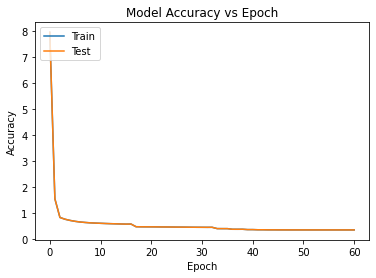

In [272]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [273]:
new_model = keras.models.load_model('Neuronales_Mejor_Modelo.hdf5')
#new_model = keras.models.load_model('Neuronales_logloss_1937_5_features.hdf5')
#new_model.save('Neuronales_logloss_1937_5_features.hdf5')
#new_model = keras.models.load_model('Neuronales_Mejor_Modelo.hdf5')
#new_predictions = new_model.predict(x_test)

In [274]:
from sklearn.metrics import accuracy_score, log_loss

y_pred_proba = new_model.predict(x_test_vector).flatten()
y_pred = [a > 0.5 for a in y_pred_proba]


#Mejor obtenido 0.94839
score = accuracy_score(y_pred, y_test_vector)
score

0.9483942414174973

In [275]:
#Mejor obtenido 0.18612

score = log_loss(y_test_vector.flatten(), y_pred_proba, eps=1e-7)
score

0.19887577775465623

In [183]:
#Probamos normalizar al intervalo (0, 1)
vector = y_pred_proba.flatten()

min_ = vector.min()
max_ = vector.max()
div = max_ - min_

for i, a in enumerate(vector):
    vector[i] = (a - min_) / div

    
score = log_loss(y_test_vector.flatten(), vector, eps=1e-7)
score

0.22026986546057614

In [188]:
new_model.evaluate(x_test_vector, y_test_vector)#, metrics=['accuracy'])

142/142 [==============================] - 0s 2ms/step - loss: 0.2134


0.21337299048900604

In [68]:
#Podemos analizar las filas que originaron los errores de prediccion

analysis_df = y_test.copy()
analysis_df['Predicted'] = pd.Series(y_pred).astype(int)
differences = (analysis_df['Predicted'] != analysis_df['Stage'])
df_test[differences]

,Sales_Contract_No,Opportunity_Name,Planned_Opportunity_Duration,Account_Name,Product_Name,Planned_Time_Until_Deliver,Bureaucratic_Code,Last_Modified_By,Opportunity_Owner,Product_Family,...,Total_Taxable_Amount_Currency,Opportunity_TRF_Region_std_Ratio,Total_Amount_Currency,ASP_Currency,Opportunity_TRF,Opportunity_Total_Amount_Region_std_Ratio,Opportunity_TRF_Region_avg_Ratio,Region,TRF,Stage
25,3709,Opportunity_Name_12017,28.0,Account_Name_1931,Product_Name_123,12.0,Bureaucratic_Code_4,Person_Name_19,Person_Name_65,Product_Family_98,...,USD,0.000000,USD,USD,0,0.201196,0.000000,APAC,0,0
32,3719,Opportunity_Name_2001,151.0,Account_Name_25,Product_Name_209,151.0,Bureaucratic_Code_4,Person_Name_8,Person_Name_8,Product_Family_128,...,USD,0.000000,USD,USD,0,0.703580,0.000000,Americas,0,0
37,3718,Opportunity_Name_2007,137.0,Account_Name_25,Product_Name_220,137.0,Bureaucratic_Code_4,Person_Name_8,Person_Name_8,Product_Family_133,...,USD,0.225311,USD,USD,4,0.778205,0.993953,Americas,1,0
41,3721,Opportunity_Name_2008,165.0,Account_Name_25,Product_Name_220,165.0,Bureaucratic_Code_4,Person_Name_8,Person_Name_8,Product_Family_133,...,USD,0.337966,USD,USD,6,1.166517,1.490930,Americas,1,0
44,3719,Opportunity_Name_2001,172.0,Account_Name_25,Product_Name_209,172.0,Bureaucratic_Code_4,Person_Name_8,Person_Name_8,Product_Family_128,...,USD,0.000000,USD,USD,0,0.703580,0.000000,Americas,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,None,Opportunity_Name_11323,32.0,Account_Name_533,Product_Name_241,21.0,Bureaucratic_Code_4,Person_Name_13,Person_Name_13,Product_Family_140,...,EUR,0.000000,EUR,EUR,0,1.614972,0.000000,EMEA,0,1
4349,5424,Opportunity_Name_3261,16.0,Account_Name_293,Product_Name_159,12.0,Bureaucratic_Code_4,Person_Name_51,Person_Name_51,Product_Family_114,...,EUR,0.000000,EUR,EUR,0,1.098812,0.000000,EMEA,0,0
4353,5424,Opportunity_Name_3261,16.0,Account_Name_293,Product_Name_190,12.0,Bureaucratic_Code_4,Person_Name_51,Person_Name_51,Product_Family_117,...,EUR,0.000000,EUR,EUR,0,1.098812,0.000000,EMEA,0,0
4369,None,Opportunity_Name_11177,11.0,Account_Name_1693,Product_Name_241,7.0,Bureaucratic_Code_4,Person_Name_13,Person_Name_13,Product_Family_140,...,EUR,0.000000,EUR,EUR,0,0.628219,0.000000,EMEA,0,1
